# Evaluacion de Resultados 

En este Notebook se muestran tecnicas de para la evaluacion de los resultados de una prediccion con un algoritmo de Machine Learning.


## Dataset

## Descripcion
ISCX NSL-KDD is a data set suggested to solve some of the inherent problems of the KDD'99 data set which are mentioned in [1]. Although, this new version of the KDD data set still suffers from some of the problems discussed by McHugh and may not be a perfect representative of existing real networks, because of the lack of public data sets for network-based IDSs, we believe it still can be applied as an effective benchmark data set to help researchers compare different intrusion detection methods.

Furthermore, the number of records in the NSL-KDD train and test sets are reasonable. This advantage makes it affordable to run the experiments on the complete set without the need to randomly select a small portion. Consequently, evaluation results of different research work will be consistent and comparable.

Data files

* <spam style="color:green">  KDDTrain+.ARFF: The full NSL-KDD train set with binary labels in ARFF format </spam>
* KDDTrain+.TXT: The full NSL-KDD train set including attack-type labels and difficulty level in CSV format
* KDDTrain+_20Percent.ARFF: A 20% subset of the KDDTrain+.arff file
* KDDTrain+_20Percent.TXT: A 20% subset of the KDDTrain+.txt file
* KDDTest+.ARFF: The full NSL-KDD test set with binary labels in ARFF format
* KDDTest+.TXT: The full NSL-KDD test set including attack-type labels and difficulty level in CSV format
* KDDTest-21.ARFF: A subset of the KDDTest+.arff file which does not include records with difficulty level of 21 out of 21
* KDDTest-21.TXT: A subset of the KDDTest+.txt file which does not include records with difficulty level of 21 out of 21

[Link de Descarga](https://www.unb.ca/cic/datasets/nsl.html) 

License
You may redistribute, republish, and mirror the ISCX NSL-KDD dataset in any form. However, any use or redistribution of the data must include a citation to the NSL-KDD dataset and the paper referenced below.

References: [1] M. Tavallaee, E. Bagheri, W. Lu, and A. Ghorbani, “A Detailed Analysis of the KDD CUP 99 Data Set,” Submitted to Second IEEE Symposium on Computational Intelligence for Security and Defense Applications (CISDA), 2009.

# Imports


In [1]:
import pandas as pd
import numpy as np
import arff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# Funsiones Auxiliares

In [2]:
import pandas as pd
import numpy as np
import arff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
def load_kdd_dataset(data_path): 
    """Lectura del dataset NSL-KDD"""
    with open(data_path, 'r') as train_set:
        dataset = arff.load(train_set)
        attributes = [attr[0] for attr in dataset["attributes"]]
    return pd.DataFrame(dataset["data"], columns=attributes)

In [4]:
# construccion de del pipeline para los atributos numericos
nump_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('rbst_scaler', RobustScaler())
])

In [5]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):

    def __init__ (self):
        self.oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self.colums_ = pd.get_dummies(X_cat).columns
        self.oh.fit(X_cat)
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self.oh.transform(X_cat)
        X_cat_oh_df = pd.DataFrame(X_cat_oh, columns=self.colums_, index=X.index)
        X_copy.drop(columns=X_cat.columns, inplace=True)
        
        return X_copy.join(X_cat_oh_df)

In [6]:
# Transformador que prepara todo el conjunto de datos llamado Pipelines y Trasnformadores personalizados
class DataFramePreparer(BaseEstimator, TransformerMixin):

    def __init__(self):
        self._full_pipeline = None
        self._columns = None
    def fit(self, X, y=None):
        num_attributes = list(X.select_dtypes(exclude=['object']).columns)
        cat_attributes = list(X.select_dtypes(include=['object']).columns)
        self._full_pipeline = ColumnTransformer([
            ('nump_pipeline', nump_pipeline, num_attributes),
            ('cat_pipeline', CustomOneHotEncoder(), cat_attributes)
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prepared = self._full_pipeline.transform(X_copy)

        return pd.DataFrame(X_prepared, 
                            columns=self._columns, 
                            index=X_copy.index)

#### Lectura de los Datos

In [7]:
df = load_kdd_dataset("./datasets/datasets/NSL-KDD/KDDTrain+.arff")

## Divicion del DataSet

In [8]:

# Split into train (70%), validation (15%), and test (15%)
train_set, temp_set = train_test_split(df, test_size=0.3, stratify=df['protocol_type'], random_state=42)
val_set, test_set = train_test_split(temp_set, test_size=0.5, stratify=temp_set['protocol_type'], random_state=42)

In [9]:
print("Longitud del training set:", len(train_set))
print("Longitud del validation set:", len(val_set)) # Corrección de sintaxis y variable
print("Longitud del test set:", len(test_set))

Longitud del training set: 88181
Longitud del validation set: 18896
Longitud del test set: 18896


Para cada uno de los subconjuntos se esperan las etiquetas de caracteristicas de entrada.

In [10]:
# Conjunto de datos General
X_df = df.drop('class' , axis=1)
y_df = df['class'].copy()

In [11]:
# conjunto de datos de entrenamiento
X_train = train_set.drop('class', axis=1)
y_train = train_set['class'].copy()

In [12]:
# conjunto de datos de validacion
X_val = val_set.drop('class', axis=1)
y_val = val_set['class'].copy()


In [13]:
# conjunto de datos de prueba 
X_test = test_set.drop('class', axis=1)
y_test = test_set['class'].copy()

## Preparacion del DataSet

In [14]:
# Instancia del preparador de datos
data_preparer = DataFramePreparer()

data_preparer.fit(X_train)

X_train_prepared = data_preparer.transform(X_train)


X_val_prepared = data_preparer.transform(X_val)


X_test_prepared = data_preparer.transform(X_test)


### Entrenamiento de un algoritmo de Regresion lo

Al Instanciar un algoritmo de ML utilizando Sklearn se realiza utilizando los metodos expuestos por la API tal como se han presentado en notebook anteriores.


In [15]:
# Entrenar el algorimo de Regresion logistica
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=5000)

clf.fit(X_train_prepared, y_train)

/home/luisantonio/Escritorio/5to/Quinto/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


### Prediccion con nuevos ejemplos
 Realizar una prediccioj con el modelo generado anteriormente tras el entrenamiento del algoritmo de regresion logistica. Utilizamos un subconjunto del conjunto de validacion para realizar la prediccion

In [16]:
y_prepred = clf.predict(X_val_prepared)

## 1.- Matriz de confusion

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(y_val, y_prepred)


array([[8367,  358],
       [ 203, 9968]])

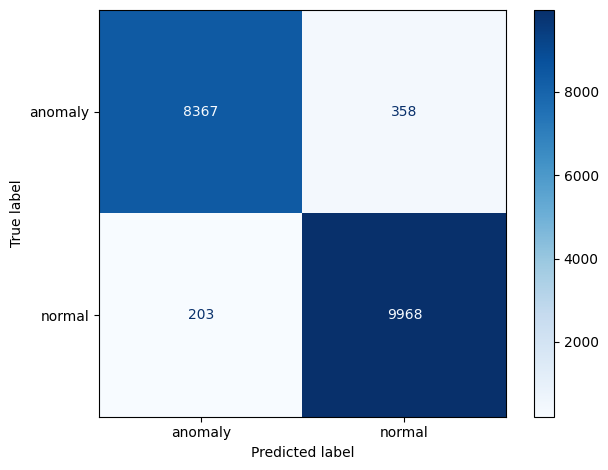

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay.from_estimator(clf, X_val_prepared, y_val, cmap='Blues')
plt.tight_layout()
plt.show()

### Metricas dervadas de la confusion

#### Precision


In [19]:
from sklearn.metrics import precision_score

print("Precision:", precision_score(y_val, y_prepred, pos_label='anomaly'))

Precision: 0.9763127187864644


### Recall

In [20]:
## Recall

from sklearn.metrics import recall_score
print("Recall:", recall_score(y_val, y_prepred, pos_label='anomaly'))


Recall: 0.9589684813753582


#### F1_Score

In [21]:
from sklearn.metrics import f1_score
print("F1 Score:", f1_score(y_val, y_prepred, pos_label='anomaly'))

F1 Score: 0.9675628794449262


## 2-. Curvas ROC y PR


# Curva ROC

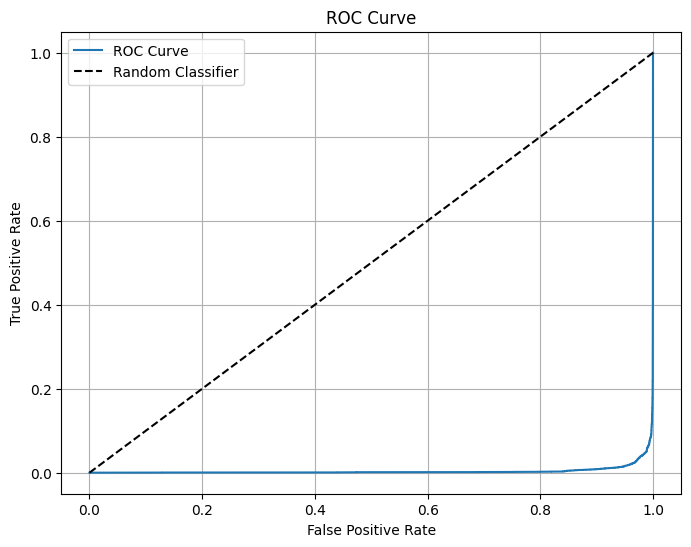

In [22]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Get probability predictions for the positive class
y_pred_proba = clf.predict_proba(X_val_prepared)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba, pos_label='anomaly')

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

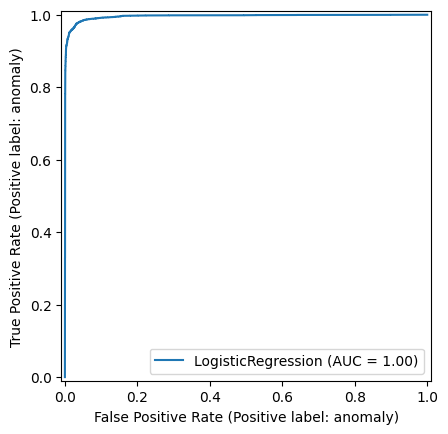

In [23]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(clf, X_val_prepared, y_val, pos_label='anomaly')

#### CurvaPR

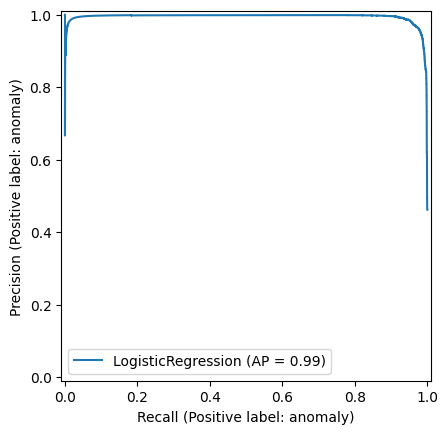

In [24]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(clf, X_val_prepared, y_val, pos_label='anomaly')


## 4.- Evaluacion del modelo con el DataSet de pruebas

In [25]:
# Transform el subconjunto de datos de validacion
X_test_prepared = data_preparer.transform(X_test)


In [26]:
y_prepred = clf.predict(X_test_prepared)

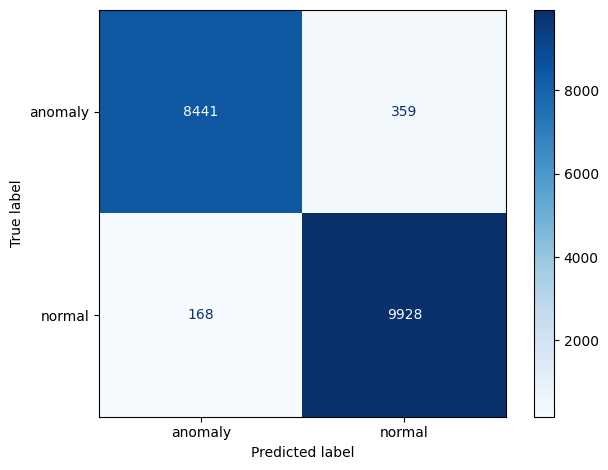

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test_prepared, y_test, cmap='Blues')
plt.tight_layout()
plt.show()